Current Time = 00:52:54

device=CPU, Hash=0, K=(2.0)
K = 2.0, T = 1, Run-time =    0.61 (sec.)
K = 2.0, T = 2, Run-time =    1.56 (sec.)

device=CPU, Hash=0, K=(2.5)
K = 2.5, T = 1, Run-time =    1.05 (sec.)
K = 2.5, T = 2, Run-time =    2.36 (sec.)

device=CPU, Hash=0, K=(3.0)
K = 3.0, T = 1, Run-time =    1.42 (sec.)
K = 3.0, T = 2, Run-time =    3.51 (sec.)

device=CPU, Hash=1, K=(2.0)
K = 2.0, T = 1, Run-time =    0.47 (sec.)
K = 2.0, T = 2, Run-time =    0.69 (sec.)

device=CPU, Hash=1, K=(2.5)
K = 2.5, T = 1, Run-time =    0.70 (sec.)
K = 2.5, T = 2, Run-time =    1.01 (sec.)

device=CPU, Hash=1, K=(3.0)
K = 3.0, T = 1, Run-time =    0.98 (sec.)
K = 3.0, T = 2, Run-time =    1.49 (sec.)

device=M-CPU, Hash=0, K=(2.0)
K = 2.0, T = 1, Run-time =    0.54 (sec.)
K = 2.0, T = 2, Run-time =    0.58 (sec.)

device=M-CPU, Hash=0, K=(2.5)
K = 2.5, T = 1, Run-time =    0.71 (sec.)
K = 2.5, T = 2, Run-time =    1.11 (sec.)

device=M-CPU, Hash=0, K=(3.0)
K = 3.0, T = 1, Run-time =    0.99 (s

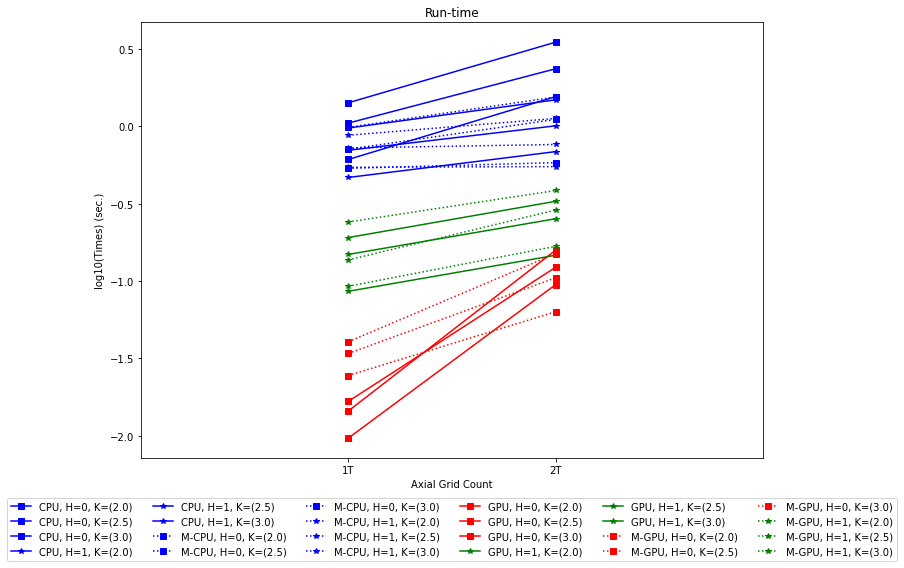

Done.
Wall time: 36.6 s


In [12]:
%%time

from IPython.display import clear_output
clear_output()

# 저니크 모멘트 계산 

from AZernike import *

# 차수에 따른 연산 속도 

print_curr_time()

line = "*"*60
line2 = "\n" + line 

def test_zernike_moments( datas, use_gpus, use_threads, use_hashs, Ks, Ts, **options ) : 
    
    if is_array( use_gpus ) :
        for use_gpu in use_gpus :
            options = {}
            options[ "debug" ] = get_option( "debug", **options )
            options[ "use_gpu" ] = use_gpu 
            options[ "use_thread"] = 0 
            options[ "use_hash" ] = 0 
            
            test_zernike_moments( datas, use_gpu, use_threads, use_hashs, Ks, Ts, **options )
        pass
    elif is_array( use_threads ) :
        for use_thread in use_threads :
            options = {}
            options[ "debug" ] = get_option( "debug", **options )
            options[ "use_gpu" ] = use_gpus 
            options[ "use_thread"] = use_thread  
            
            test_zernike_moments( datas, use_gpus, use_thread, use_hashs, Ks, Ts, **options )
        pass        
    elif is_array( use_hashs ) :
        for use_hash in use_hashs :
            options = {}
            options[ "debug" ] = get_option( "debug", **options )
            options[ "use_gpu" ] = use_gpus 
            options[ "use_thread"] = use_threads
            options[ "use_hash" ] = use_hash
            
            test_zernike_moments( datas, use_gpus, use_threads, use_hash, Ks, Ts, **options )
        pass 
    else :
        debug = get_option( "debug", **options )
        use_hash = get_option( "use_hash", ** options )
        use_thread = get_option( "use_thread", **options )
        use_gpu = get_option( "use_gpu", **options )
    
        device = "GPU" if use_gpu else "CPU"
        multi = "M-" if use_thread else ""
        
        if is_scalar( Ks ) :
            Ks = [ Ks ]
        pass
    
        if is_scalar( Ts ) :
            Ts = [ Ts ]
        pass 
        
        key = None
        for K in Ks :
                        
            if len( Ts ) > 1 : 
                key = f"{multi}{device}, Hash={use_hash}, K=({K})"
            else :
                key = f"{multi}{device}, Hash={use_hash}"
            pass    
            
            if not key in datas :
                print()
                print( f"device={key}")
            
                data = {}
                data[ "Ks"] = Ks
                data[ "Ts"] = Ts
                data[ "run_times" ] = []
                datas[ key ] = data 
            pass
        
            data = datas[ key ]
            
            run_times = data[ "run_times" ]
        
            options[ "hash" ] = {} 
            
            circle_type = "outer" 

            rho, theta, x, y, dx, dy, k, area = rho_theta( 1000*K, circle_type, **options ) 

            if debug : print( f"rho shape = {rho.shape}" )

            img = cv.imread( 'image/lenna.png', 0 )

            if debug : print( "img shape= ", img.shape )

            img_org = img 

            np = cupy if options['use_gpu'] else numpy

            img = cv.resize( img_org, (int(K*1_000), int(K*1_000)), interpolation=cv.INTER_AREA )

            if options['use_gpu']  : 
                img = np.array( img )
            pass

            img_org = img

            if debug : 
                print( "img shape= ", img.shape ) 
                print( line )
            pass
        
            for T in Ts :
                moments, run_time = calc_moments(T, img, rho, theta, dx, dy, **options )
                
                print( f"K = {K}, T = {T}, Run-time = {run_time:7.2f} (sec.)" ) 
                
                run_times.append( run_time )
            pass # T
        pass # K
    pass
pass # test_zernike_moments

def plot_result( datas ) : 

    print( "\nPlotting .... ")
        
    # 서브 챠트 생성 
    row_cnt = 1
    col_cnt = 1

    fig, charts = plt.subplots( row_cnt, col_cnt, figsize=(12*col_cnt, 8*row_cnt) )
    charts = charts.ravel() if row_cnt*col_cnt > 1 else [charts]
    chart_idx = 0 
    chart = charts[ chart_idx ] ; chart_idx += 1
    
    for key in datas : 
        data = datas[ key ]
        
        Ks = data[ "Ks" ]
        Ts = data[ "Ts" ]
        
        run_times = data[ "run_times" ]
        
        x = Ts if "K" in key else Ks
        y = numpy.log10( run_times ) 
        
        label = f"{key}"
        
        linestyle = "solid"
        
        if "M" in label :
            linestyle = "dotted"
        pass
        
        color = "b"
        
        if "GPU" in label :
            color = "g"
        pass

        marker = "*"
        if "Hash=0" in label : 
            marker = "s" 
            if "GPU" in label :
                color = "r"
            pass 
        pass
    
        label = label.replace( "Hash", "H" )

        chart.plot( x, y, marker=marker, color=color, label=label, linestyle=linestyle )
        
        title = f"Run-time"
        
        if len(Ks) == 1 :
            title = f"Run-time(K={Ks[0]})"
        elif len(Ts) == 1 :
            title = f"Run-time(T={Ts[0]})"
        pass
    
        chart.set_title( title ) 
        
        chart.set_xlabel( "Axial Grid Count" )
        chart.set_ylabel( "log10(Times) (sec.)")
        chart.set_xticks( x )
        if "K" in key :
            chart.set_xticklabels( [ f"{t}T" for t in x ] )
        else :
            chart.set_xticklabels( [ f"{k}K" for k in x ] )
        pass    
        chart.set_xlim( numpy.min(x) - 1, numpy.max(x) + 1 )
        
        n = len( datas ) 
        ncol = 4
        for i in range( 2, 8 ) :
            if n % i == 0 :
                ncol = i 
            pass
        pass
        
        chart.legend(loc="upper center", bbox_to_anchor=(0.5, -0.08), ncol=ncol) 
    pass

    plt.tight_layout(); plt.show()
pass # plot_result
    
use_gpus    = [ 0, 1 ]
use_threads = [ 0, 1 ]
use_hashs   = [ 0, 1 ]

Ks = numpy.arange( 2, 3.1, 0.5 ) 

T_MAX = 25 

max_mem = max_gpu_memory() if False else max_cpu_memory() 

if max_mem < 8 :
    T_MAX = 18
elif max_mem < 25 :
    T_MAX = 20
pass

T_MAX = 2 

T = T_MAX 

T = [ T//2, T ]

datas = { }

debug = 0

test_zernike_moments( datas, use_gpus, use_threads, use_hashs, Ks, T, debug=debug ) 

plot_result( datas )

print( "Done." )
